In [1]:
from datetime import date, timedelta
from constants import *
from bars import plot_with_diff as plot_areas
from phe import *
from phe import map_data as phe_map_data
from zoe import latest_map_data as zoe_map_data
from plotting import *
from vaccination import vaccination_dashboard, vaccination_changes
for_date = '*'

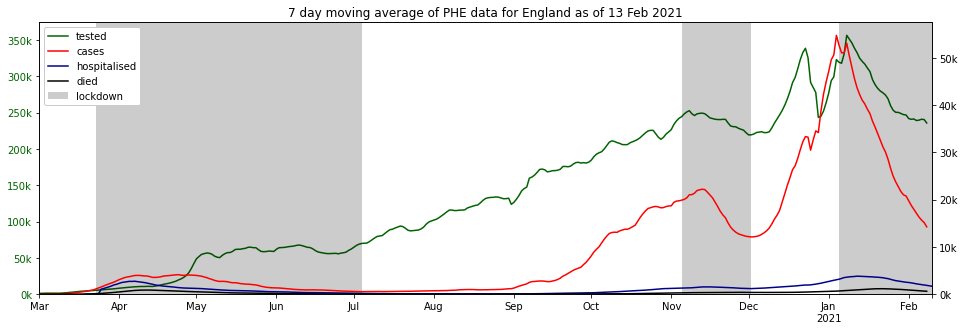

In [2]:
plot_summary(earliest_date='2020-03-01')

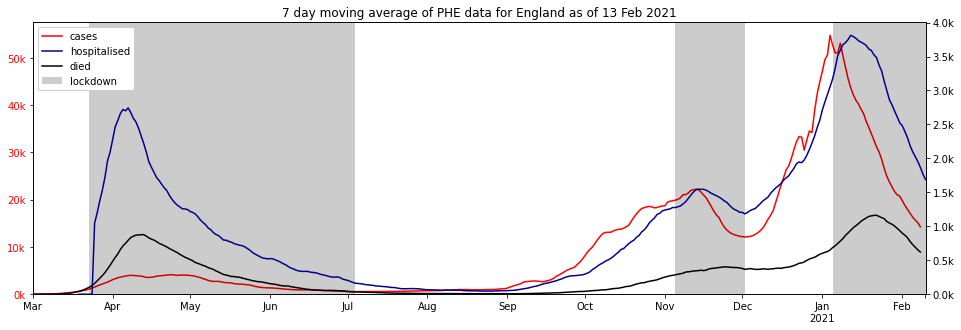

In [3]:
plot_summary(earliest_date='2020-03-01', left_series=(s.new_cases_sum,), 
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0k_formatter)

,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,England,E92000001,487699.0,12246166.0,11758467.0,56286961,0.866451,20.890215,78.243334
1,Northern Ireland,N92000002,28937.0,387771.0,358834.0,1893667,1.528093,18.949161,79.522746
2,Scotland,S92000003,14009.0,1173445.0,1159436.0,5463300,0.256420,21.222265,78.521315
3,Wales,W92000004,4224.0,749445.0,745221.0,3152879,0.133973,23.636207,76.229820


'partial: 14,556,827'

'full: 534,869'

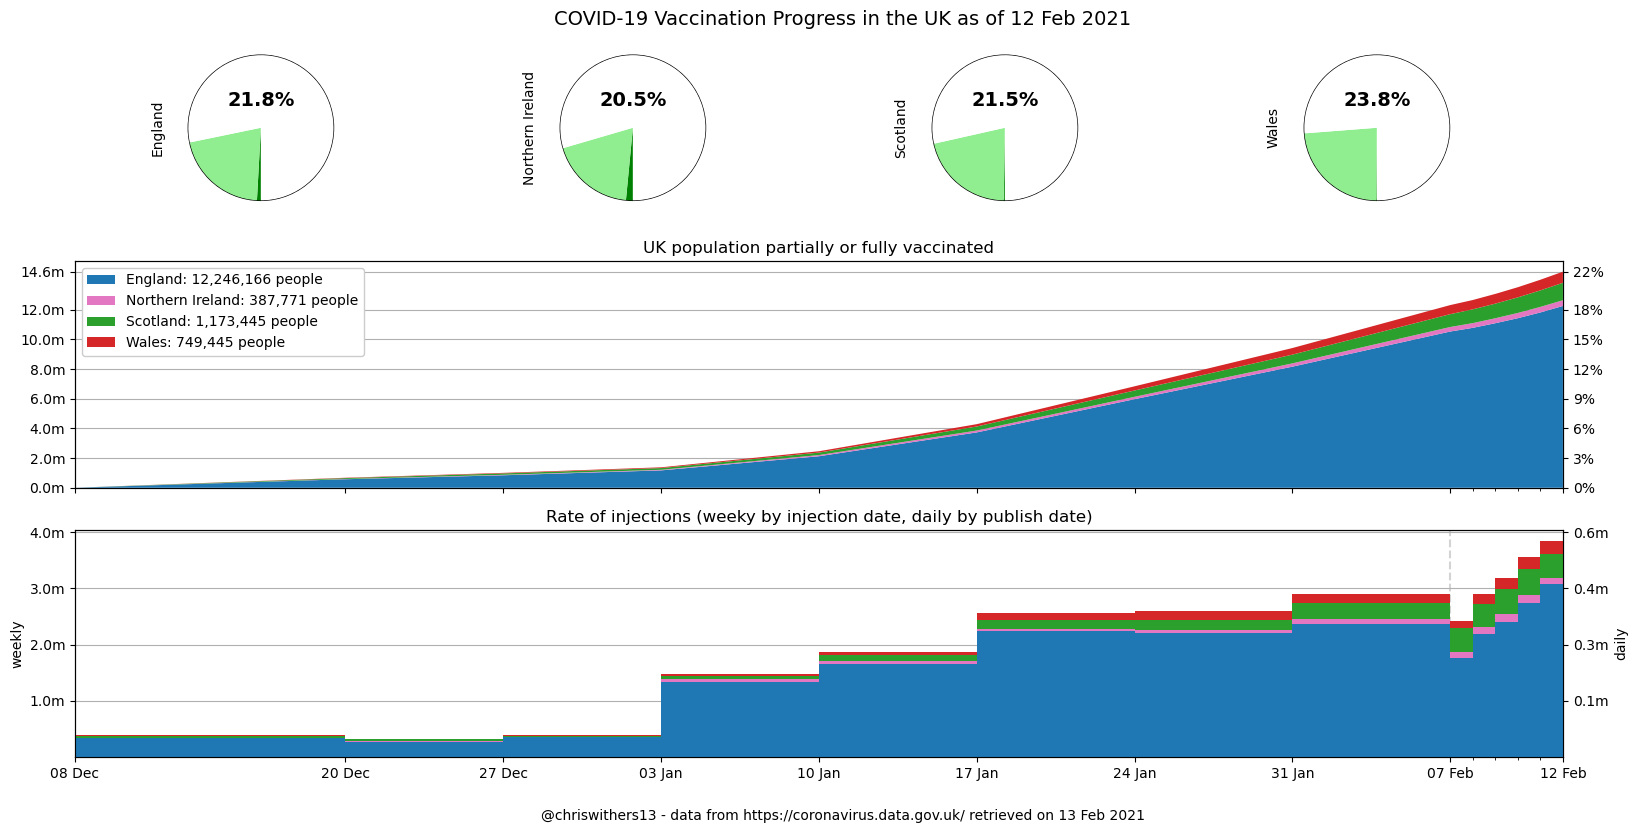

In [4]:
results = vaccination_dashboard()
display(results, f"partial: {results['any'].sum():,.0f}", f"full: {results['full'].sum():,.0f}")

In [5]:
vaccination_changes()

,,First Dose (New),Second Dose (Total),Complete (New),First Dose (Total),cumPeopleVaccinatedSecondDoseByPublishDate,Complete (Total)
,,,,,,,
England,12 Feb 21,"+436,925","+3,733","+3,733","+12,246,166","+487,699","+487,699"
Northern Ireland,12 Feb 21,"+14,357",+385,+385,"+387,771","+28,937","+28,937"
Scotland,12 Feb 21,"+59,820",+443,+443,"+1,173,445","+14,009","+14,009"
Wales,12 Feb 21,"+33,501",+214,+214,"+749,445","+4,224","+4,224"


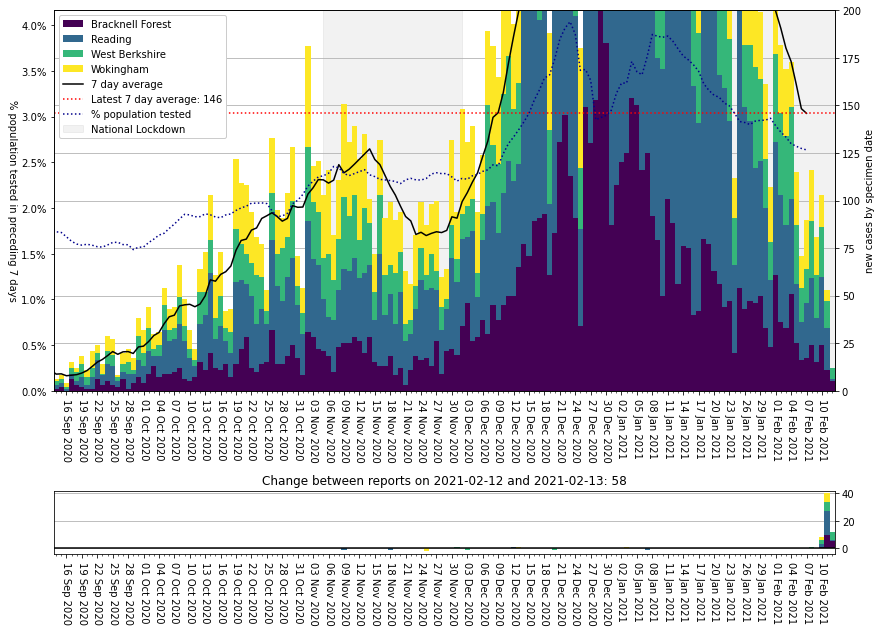

In [2]:
plot_areas(for_date, areas=my_areas, earliest='2020-09-14', ylim=200)

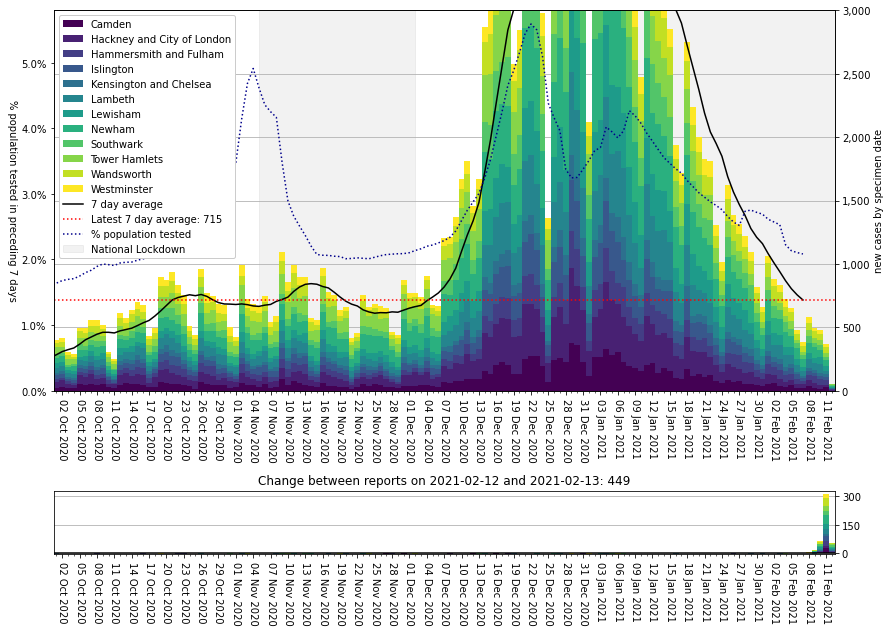

In [3]:
plot_areas(for_date, areas=london_areas, ylim=3_000)

In [4]:
data = recent_phe_data_summed(for_date)
top_10_cols = [area_name,per100k,new_cases_by_specimen_date, specimen_date]

In [5]:
top_10 = data.sort_values(per100k, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E06000002,Middlesbrough,280.181586,395.0,2021-02-12
E07000150,Corby,279.708660,202.0,2021-02-12
S12000008,East Ayrshire,262.273584,320.0,2021-02-12
E07000170,Ashfield,251.723761,322.0,2021-02-12
E08000028,Sandwell,247.221799,812.0,2021-02-12
E08000013,St. Helens,242.545062,438.0,2021-02-12
E08000011,Knowsley,239.954395,362.0,2021-02-12
E08000030,Walsall,231.541485,661.0,2021-02-12
E07000174,Mansfield,231.445482,253.0,2021-02-12


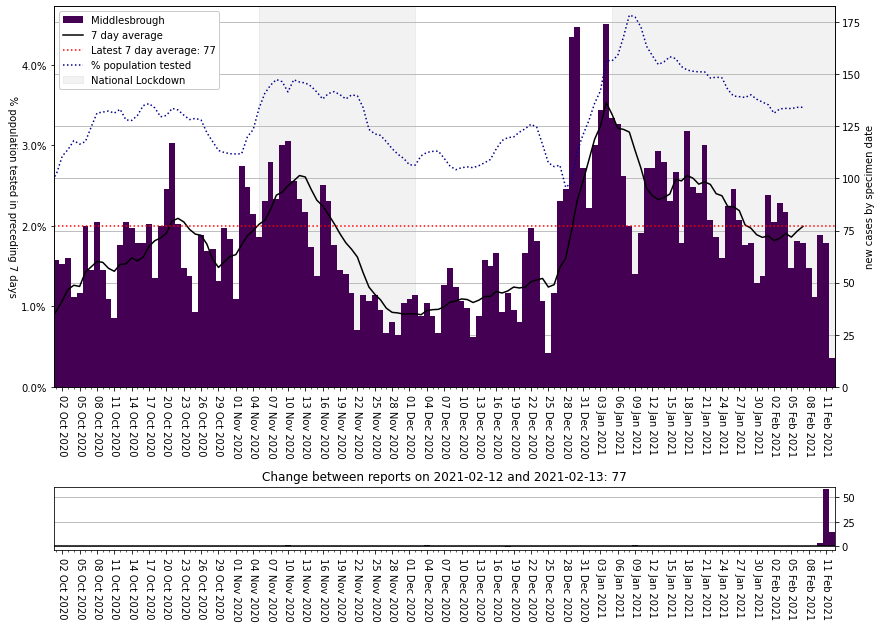

In [6]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [7]:
top_10 = data.sort_values(new_cases_by_specimen_date, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E08000025,Birmingham,190.923932,2180.0,2021-02-12
E08000035,Leeds,137.428622,1090.0,2021-02-12
E08000032,Bradford,182.853628,987.0,2021-02-12
E08000012,Liverpool,178.097430,887.0,2021-02-12
E08000003,Manchester,153.746532,850.0,2021-02-12
E08000028,Sandwell,247.221799,812.0,2021-02-12
S12000049,Glasgow City,127.306040,806.0,2021-02-12
E06000016,Leicester,217.376575,770.0,2021-02-12
E06000047,County Durham,138.277362,733.0,2021-02-12


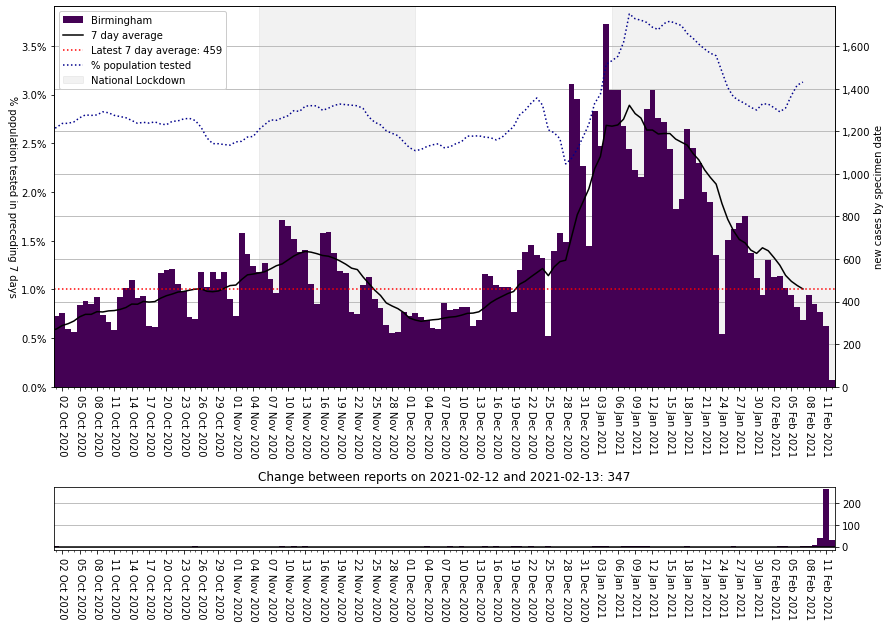

In [8]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [9]:
zoe_date, zoe_df = zoe_map_data()
phe_recent_date, phe_recent_geo, phe_recent_title = phe_map_data(for_date)

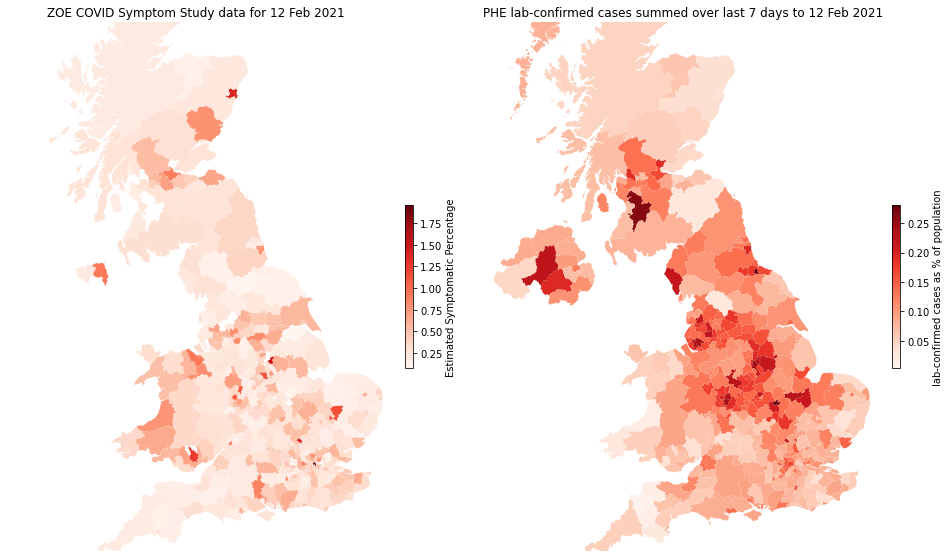

In [10]:
matplotlib_zoe_vs_phe_map(zoe_df, zoe_date, phe_recent_geo, phe_recent_title)   

In [11]:
bokeh_zoe_vs_phe_map(zoe_df, zoe_date, phe_recent_geo, phe_recent_title)

Loading BokehJS ...

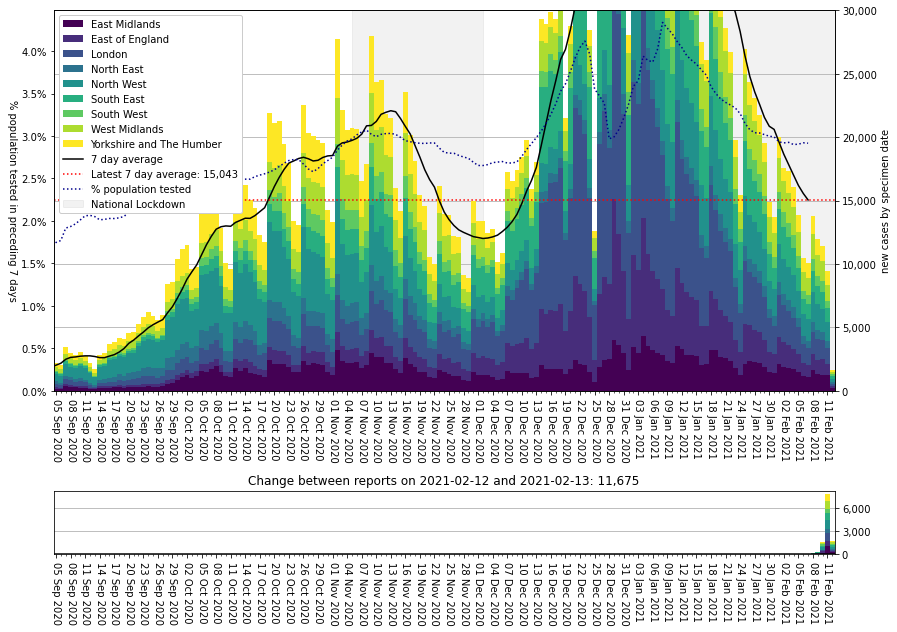

In [12]:
plot_areas(for_date, area_type=region, ylim=30_000, earliest='2020-09-05')

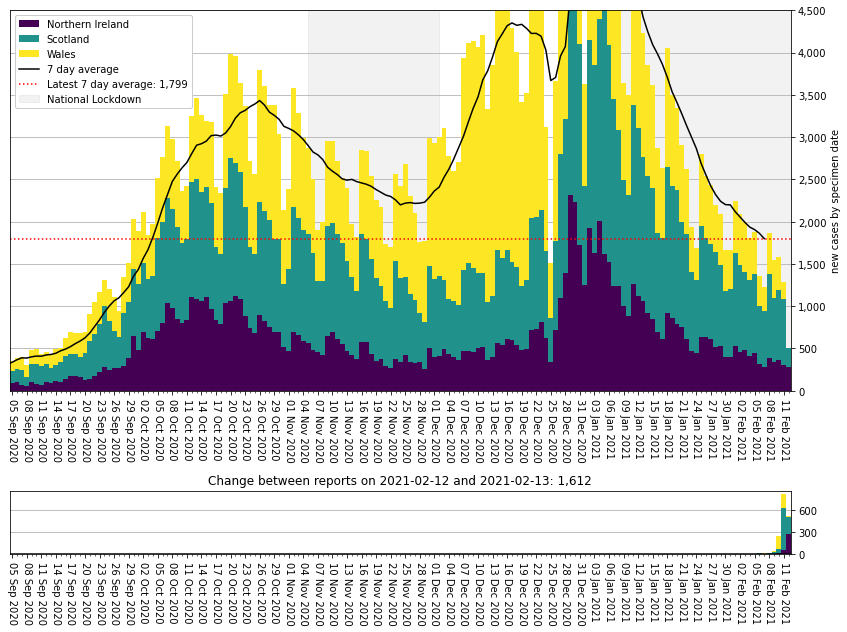

In [15]:
plot_areas(for_date, 'cases_devolved', ylim=4_500, diff_ylims=None, earliest='2020-09-05')